In [4]:
import xgboost as xgb
import numpy as np
import scipy.io as io
import plotly.offline as py
import plotly.graph_objs as go
import json

py.init_notebook_mode(connected=True)

In [5]:
mat = io.loadmat('data_Mg_GBperatom_seg_2Al_dump.mat')

length_A = mat['A'].shape[1]

In [6]:
for i in range(30):
    segE = mat['A']['Eseg'][0,i]
    #check whether this is a valid data?
    n1 = segE[:,0] != 0 
    segE = np.squeeze(segE[n1,:])
    atom_ID = segE[:,0].astype(int) - 1

    descriptor = mat['A']['peratom'][0,i][0,0]
    descriptor_temp = np.concatenate([descriptor['pos'],descriptor['pe'],descriptor['cna'],descriptor['centro_fnn'],
                                descriptor['centro_snn'],descriptor['coord'],descriptor['f'],descriptor['stress'],
                                descriptor['voronoi']], axis = 1)
    if i == 0:
        descriptor_all = descriptor_temp[atom_ID]
        segE_all = segE
    else:
        descriptor_temp = descriptor_temp[atom_ID]
        descriptor_all = np.concatenate([descriptor_all, descriptor_temp], axis = 0)
        segE_all = np.concatenate([segE_all, segE])

descriptor_all[:,2] = abs(descriptor_all[:,2]-min(descriptor_all[:,2])-20)
sigma_H = np.sum(descriptor_all[:,11:14], axis = 1)/3
f_mag = np.linalg.norm(descriptor_all[:,8:11], axis = 1, ord = 2)

feature = np.concatenate([descriptor_all, sigma_H[:,np.newaxis], f_mag[:,np.newaxis]], axis = 1)

In [7]:
y_true = segE_all[:,1]
#We should consider the coordinates don't matter.
feature1 = feature[:,3:]
feature1 = feature1/np.max(feature1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature1], axis = 1)
w = np.random.randn(38)
λ = 0
#random shuffle
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
y_true = y_true[idx0]
#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)
#X_train[:,1:] = (X_train[:,1:] - mean[1:])/std[1:]
X_temp = feature_space[int(len(feature_space)*.7):]
#X_temp[:,1:] = (X_temp[:,1:] - mean[1:])/std[1:]
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]
Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]

# 1st order gradient boosting

In [5]:
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_cos, Y_cos)

In [6]:
param = {'verbosity':1, 'booster':'gblinear','lambda': 0}

In [7]:
watchlist = [(dtest, 'eval'),(dtrain, 'train')]
num_round = 40
model = xgb.train(param, dtrain, num_round, watchlist)


[0]	eval-rmse:0.113563	train-rmse:0.112792
[1]	eval-rmse:0.038435	train-rmse:0.037793
[2]	eval-rmse:0.027408	train-rmse:0.027096
[3]	eval-rmse:0.026231	train-rmse:0.026013
[4]	eval-rmse:0.025961	train-rmse:0.025777
[5]	eval-rmse:0.025852	train-rmse:0.025656
[6]	eval-rmse:0.025793	train-rmse:0.025583
[7]	eval-rmse:0.025743	train-rmse:0.025539
[8]	eval-rmse:0.025728	train-rmse:0.025508
[9]	eval-rmse:0.025705	train-rmse:0.02549
[10]	eval-rmse:0.025713	train-rmse:0.025477
[11]	eval-rmse:0.025698	train-rmse:0.025469
[12]	eval-rmse:0.025692	train-rmse:0.025464
[13]	eval-rmse:0.025695	train-rmse:0.025461
[14]	eval-rmse:0.025689	train-rmse:0.025459
[15]	eval-rmse:0.025689	train-rmse:0.025458
[16]	eval-rmse:0.025688	train-rmse:0.025457
[17]	eval-rmse:0.025688	train-rmse:0.025456
[18]	eval-rmse:0.025688	train-rmse:0.025456
[19]	eval-rmse:0.025688	train-rmse:0.025456
[20]	eval-rmse:0.025688	train-rmse:0.025456
[21]	eval-rmse:0.025688	train-rmse:0.025456
[22]	eval-rmse:0.025688	train-rmse:0.025455

In [8]:
np.linalg.norm(model.predict(dtest) - dtest.get_label(),2)

1.1869715

In [9]:
Y_mean = np.mean(Y_cos)
SS_tot = np.sum(np.power(Y_cos - Y_mean, 2))
SS_res = np.power(np.linalg.norm(model.predict(dtest) - dtest.get_label()), 2)
R_squared = 1-SS_res/SS_tot

In [10]:
R_squared

0.668228239841913

In [11]:
SS_tot

4.246598470253312

In [12]:
SS_res

1.408901449160581

In [13]:
model.predict(dtest) - dtest.get_label()

array([ 0.00088923, -0.01809963, -0.00123879, ..., -0.00962932,
        0.0142701 ,  0.00186391], dtype=float32)

In [14]:
w_pre=np.linalg.pinv(X_train).dot(Y_train)
y1_pre = X_train.dot(w_pre)
np.power(np.linalg.norm(y1_pre-Y_train), 2)

2.489204324034974

In [15]:
Y_pre_test = X_cos.dot(w_pre)
Y_mean = np.mean(Y_cos)
SS_tot = np.sum(np.power(Y_cos - Y_mean, 2))
SS_res = np.power(np.linalg.norm(Y_pre_test-Y_cos), 2)
R_squared = 1-SS_res/SS_tot

In [16]:
R_squared

0.870141127216479

In [17]:
SS_res/Y_cos.shape

array([0.00025829])

In [18]:
SS_tot

4.246598470253312

In [19]:
Y_pre_test - Y_test

array([-0.01546949, -0.00833132,  0.00290986, ...,  0.04061351,
        0.0113742 , -0.0393585 ])

# gradient boost with interaction term

In [41]:
y_true = segE_all[:,1]
#We should consider the coordinates don't matter.
pos = feature[:,:3]
feature1 = feature[:,3:]
feature1 = feature1/np.max(feature1)
feature2 = np.zeros([feature1.shape[0], 18*18])
for i in range(18):
    feature2[:,i*18:i*18+18] = feature1[:,i][:,np.newaxis]*feature1[:,:]
feature_space = np.concatenate([feature1, feature2], axis = 1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature_space], axis = 1)
np.random.seed(10)
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
pos = pos[idx0]
y_true = y_true[idx0]
#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
#mean = np.mean(X_train, axis = 0)
#std = np.std(X_train, axis = 0)
#X_train = (X_train - mean)/std
X_temp = feature_space[int(len(feature_space)*.7):]
#X_temp = (X_temp - mean)/std
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]
Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]
pos_test = pos[int(len(pos)*.85):,:]

In [42]:
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test, Y_test)

In [43]:
param = {'verbosity':1, 'booster':'gblinear','lambda': 0, 'alpha': 0}

In [44]:
watchlist = [(dtest, 'eval'),(dtrain, 'train')]
num_round = 40
model = xgb.train(param, dtrain, num_round, watchlist)


[0]	eval-rmse:0.10448	train-rmse:0.104146
[1]	eval-rmse:0.041567	train-rmse:0.041457
[2]	eval-rmse:0.027833	train-rmse:0.027511
[3]	eval-rmse:0.024967	train-rmse:0.024483
[4]	eval-rmse:0.024318	train-rmse:0.023707
[5]	eval-rmse:0.024052	train-rmse:0.023426
[6]	eval-rmse:0.0239	train-rmse:0.023307
[7]	eval-rmse:0.023841	train-rmse:0.023242
[8]	eval-rmse:0.023812	train-rmse:0.023186
[9]	eval-rmse:0.023765	train-rmse:0.023149
[10]	eval-rmse:0.023746	train-rmse:0.023113
[11]	eval-rmse:0.023708	train-rmse:0.023087
[12]	eval-rmse:0.023697	train-rmse:0.023057
[13]	eval-rmse:0.023667	train-rmse:0.023037
[14]	eval-rmse:0.02366	train-rmse:0.023013
[15]	eval-rmse:0.023652	train-rmse:0.022995
[16]	eval-rmse:0.023636	train-rmse:0.02298
[17]	eval-rmse:0.023616	train-rmse:0.022966
[18]	eval-rmse:0.023612	train-rmse:0.022953
[19]	eval-rmse:0.023602	train-rmse:0.02294
[20]	eval-rmse:0.023593	train-rmse:0.02293
[21]	eval-rmse:0.023586	train-rmse:0.02292
[22]	eval-rmse:0.023576	train-rmse:0.022911
[23]	e

In [45]:
dtest.get_label()

array([0.06559778, 0.06282532, 0.05779207, ..., 0.05025972, 0.07115129,
       0.07881535], dtype=float32)

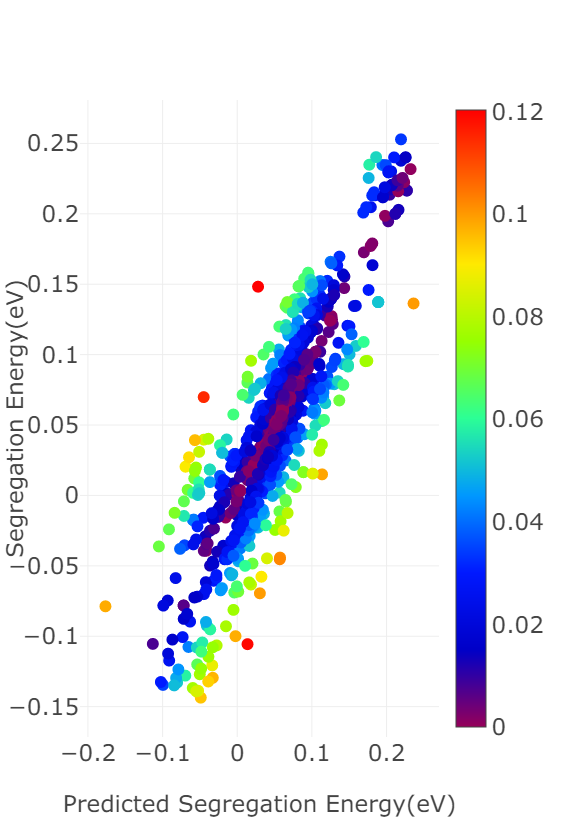

In [51]:
main = go.Scatter(x = model.predict(dtest) , 
                y = dtest.get_label(),
                text = np.around(abs(model.predict(dtest) - dtest.get_label()),3).tolist(),
                hoverinfo = 'text',
                marker={'size':12, 'color':abs(model.predict(dtest) - dtest.get_label()), 'colorscale':'Rainbow' ,
                'symbol':'circle','showscale':True, 'colorbar':dict(tickfont = dict(size = 23))}, 
                mode='markers'
                )
data = [main]

layout = go.Layout(autosize = False,
            height = 800,
            width = 800,     
             xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
            yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)}
            )
fig = go.Figure(data = data, layout = layout)
plot = py.iplot(fig)

In [48]:
model.predict(dtest)

array([0.06173649, 0.06006058, 0.05975693, ..., 0.05270867, 0.06236856,
       0.07206   ], dtype=float32)

In [52]:
Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.power(np.linalg.norm(model.predict(dtest) - dtest.get_label()), 2)
R_squared = 1-SS_res/SS_tot
R_squared = 1-(1-R_squared)*(X_train.shape[0]-1)/(X_train.shape[0]-1-X_train.shape[1])

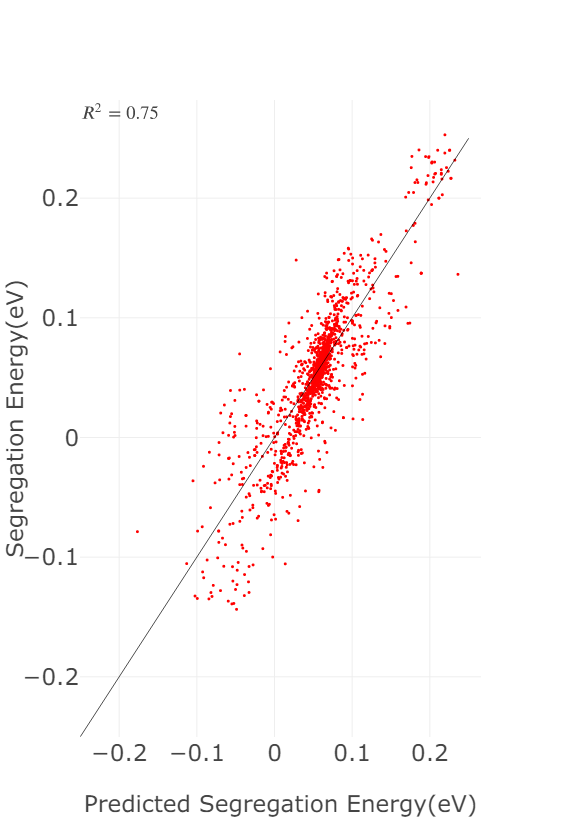

In [53]:
#draw correlation
main = go.Scatter(x = model.predict(dtest), 
          y = dtest.get_label(), 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 23)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':0.25,
                            'y0':-0.25,
                            'y1':0.25,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

# gradient boost with tree regression

In [8]:
dtrain = xgb.DMatrix(X_train, Y_train)
dcos = xgb.DMatrix(X_cos, Y_cos)
dtest = xgb.DMatrix(X_test, Y_test)
param = {'verbosity':1, 'booster':'gbtree','eta': 0.3, 'max_depth': 25, 'subsample': 0.5, 'lambda':0.08,'alpha':0.01}

In [9]:
watchlist = [(dtest, 'eval'),(dtrain, 'train')]
num_round = 80
model = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-rmse:0.312675	train-rmse:0.312373
[1]	eval-rmse:0.219179	train-rmse:0.218951
[2]	eval-rmse:0.153665	train-rmse:0.153533
[3]	eval-rmse:0.107954	train-rmse:0.107854
[4]	eval-rmse:0.075984	train-rmse:0.075938
[5]	eval-rmse:0.053726	train-rmse:0.053622
[6]	eval-rmse:0.038379	train-rmse:0.038126
[7]	eval-rmse:0.02807	train-rmse:0.027454
[8]	eval-rmse:0.021102	train-rmse:0.02006
[9]	eval-rmse:0.016567	train-rmse:0.015057
[10]	eval-rmse:0.0138	train-rmse:0.011592
[11]	eval-rmse:0.012084	train-rmse:0.009207
[12]	eval-rmse:0.011087	train-rmse:0.007575
[13]	eval-rmse:0.010549	train-rmse:0.006421
[14]	eval-rmse:0.010293	train-rmse:0.005622
[15]	eval-rmse:0.010078	train-rmse:0.005068
[16]	eval-rmse:0.009927	train-rmse:0.00461
[17]	eval-rmse:0.009816	train-rmse:0.004278
[18]	eval-rmse:0.009711	train-rmse:0.003954
[19]	eval-rmse:0.009644	train-rmse:0.003651
[20]	eval-rmse:0.009616	train-rmse:0.003415
[21]	eval-rmse:0.009593	train-rmse:0.003206
[22]	eval-rmse:0.009576	train-rmse:0.003056
[23

eval-rmse:0.009915 lambda2=0.1 lambda1=0.01
eval-rmse:0.009881 lambda2=0.08 lambda1=0.01

In [10]:
model.predict(dtest) - dtest.get_label()

array([-0.03368082, -0.00379346,  0.00015379, ...,  0.00113103,
       -0.00052392,  0.00027719], dtype=float32)

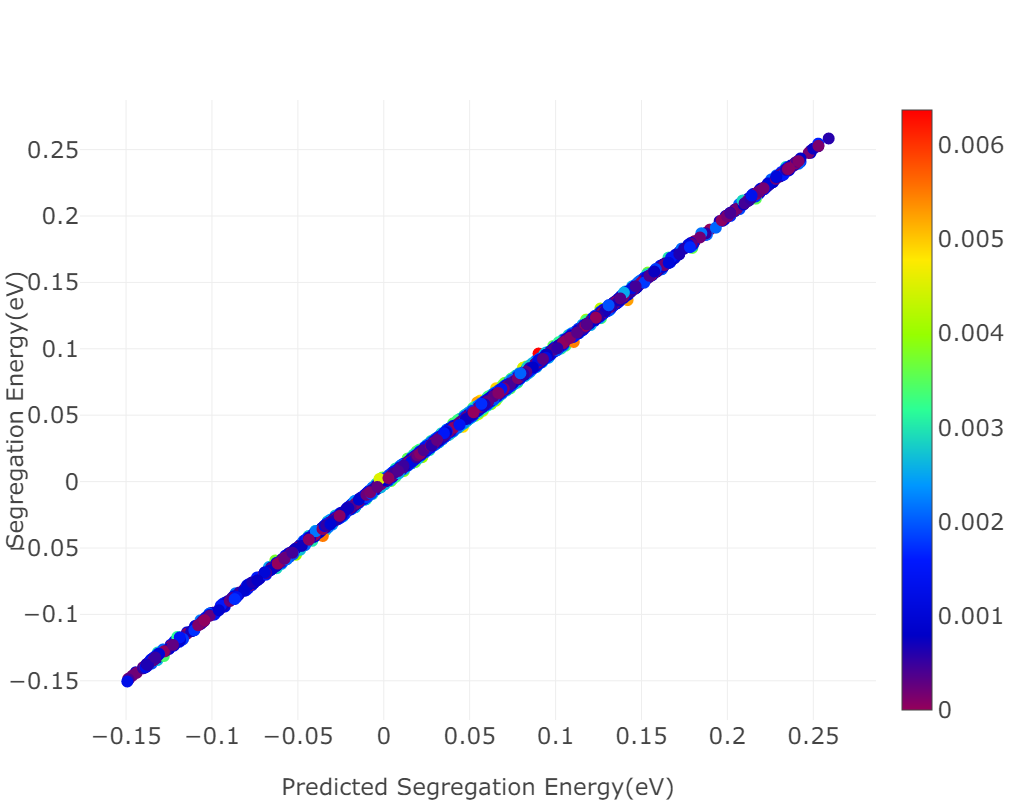

In [12]:
main = go.Scatter(x = model.predict(dtrain) , 
                y = dtrain.get_label(),
                text = np.around(abs(model.predict(dtrain) - dtrain.get_label()),3).tolist(),
                hoverinfo = 'text',
                marker={'size':12, 'color':abs(model.predict(dtrain) - dtrain.get_label()), 'colorscale':'Rainbow' ,
                'symbol':'circle','showscale':True, 'colorbar':dict(tickfont = dict(size = 23))}, 
                mode='markers'
                )
data = [main]

layout = go.Layout(autosize = False,
            height = 800,
            width = 800,     
            xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
            yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)}
            )
fig = go.Figure(data = data, layout = layout)
plot = py.iplot(fig)

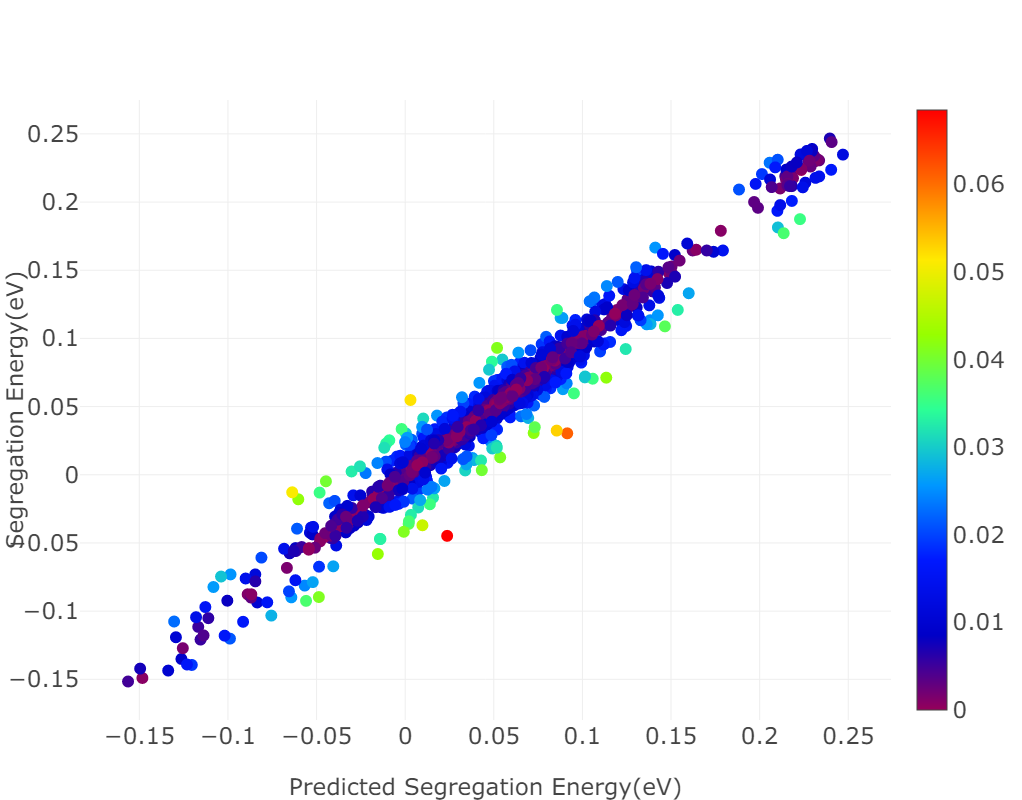

In [13]:
main = go.Scatter(x = model.predict(dcos) , 
                y = dcos.get_label(),
                text = np.around(abs(model.predict(dcos) - dcos.get_label()),3).tolist(),
                hoverinfo = 'text',
                marker={'size':12, 'color':abs(model.predict(dcos) - dcos.get_label()), 'colorscale':'Rainbow' ,
                'symbol':'circle','showscale':True, 'colorbar':dict(tickfont = dict(size = 23))}, 
                mode='markers'
                )
data = [main]

layout = go.Layout(autosize = False,
            height = 800,
            width = 800,     
            xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
            yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)}
            )
fig = go.Figure(data = data, layout = layout)
plot = py.iplot(fig)

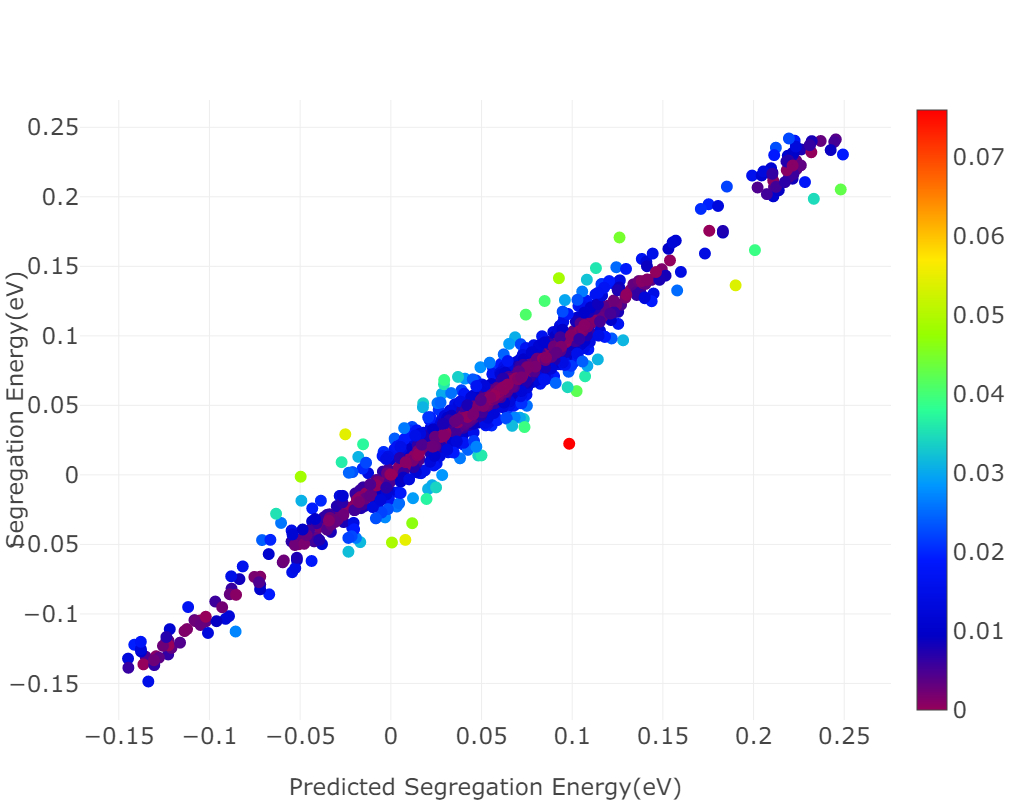

In [11]:
main = go.Scatter(x = model.predict(dtest) , 
                y = dtest.get_label(),
                text = np.around(abs(model.predict(dtest) - dtest.get_label()),3).tolist(),
                hoverinfo = 'text',
                marker={'size':12, 'color':abs(model.predict(dtest) - dtest.get_label()), 'colorscale':'Rainbow' ,
                'symbol':'circle','showscale':True, 'colorbar':dict(tickfont = dict(size = 23))}, 
                mode='markers'
                )
data = [main]

layout = go.Layout(autosize = False,
            height = 800,
            width = 800,     
            xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
            yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)}
            )
fig = go.Figure(data = data, layout = layout)
plot = py.iplot(fig)

In [58]:
Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.power(np.linalg.norm(model.predict(dtest) - dtest.get_label()), 2)
R_squared = 1-SS_res/SS_tot
R_squared = 1-(1-R_squared)*(X_train.shape[0]-1)/(X_train.shape[0]-1-X_train.shape[1])

In [59]:
Ep = np.divide(abs(model.predict(dtest) - dtest.get_label()), abs(Y_test))

In [60]:
dtest.get_label() - Y_test

array([ 2.83570012e-09,  2.33729702e-09,  1.21316157e-09, ...,
        4.96479746e-10,  9.51227097e-10, -2.26474617e-09])

In [61]:
Y_test

array([0.06559778, 0.06282532, 0.05779207, ..., 0.05025972, 0.07115129,
       0.07881535])

In [62]:
R_squared

0.9504586942615723

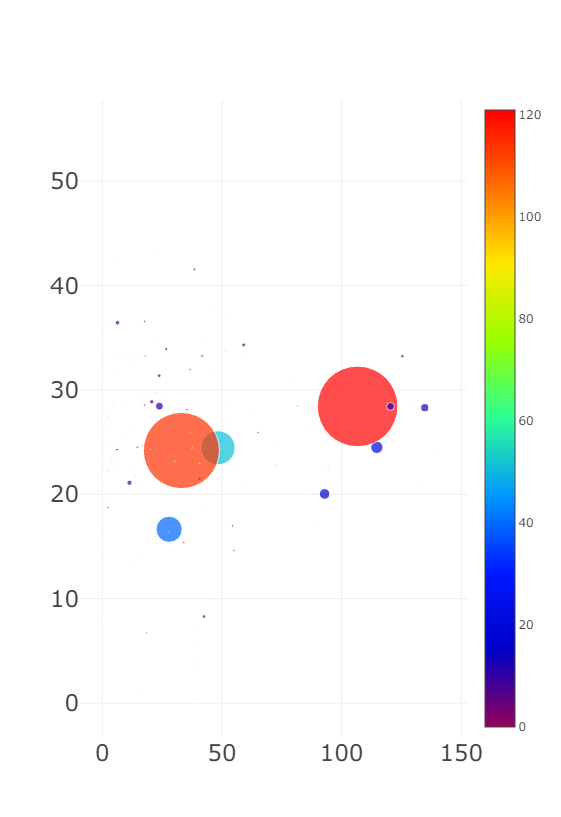

In [63]:
 main = go.Scatter(x = pos_test[:,0], 
                y = pos_test[:,2],
                text = np.around(Ep,3).tolist(),
                hoverinfo = 'text',
                marker={'size':Ep/1.5, 'color':Ep, 'colorscale':'Rainbow' ,
                'symbol':'circle','showscale':True}, 
                mode='markers'
                )
data = [main]

layout = go.Layout(autosize = False,
                    height = 800,
                    width = 1200/np.ptp(pos_test[:,2])*np.ptp(pos_test[:,0]),     
                    xaxis={'zeroline':False, 'tickfont':dict(size = 23)},
                    yaxis = {'zeroline':False, 'tickfont':dict(size = 23)}   
                    )
fig = go.Figure(data = data, layout = layout)
plot = py.iplot(fig)

In [14]:
Y_mean = np.mean(Y_train)
SS_tot = np.sum(np.power(Y_train - Y_mean, 2))
SS_res = np.power(np.linalg.norm(model.predict(dtrain) - dtrain.get_label()), 2)
R_squared = 1-SS_res/SS_tot
R_squared = 1-(1-R_squared)*(X_train.shape[0]-1)/(X_train.shape[0]-1-X_train.shape[1])

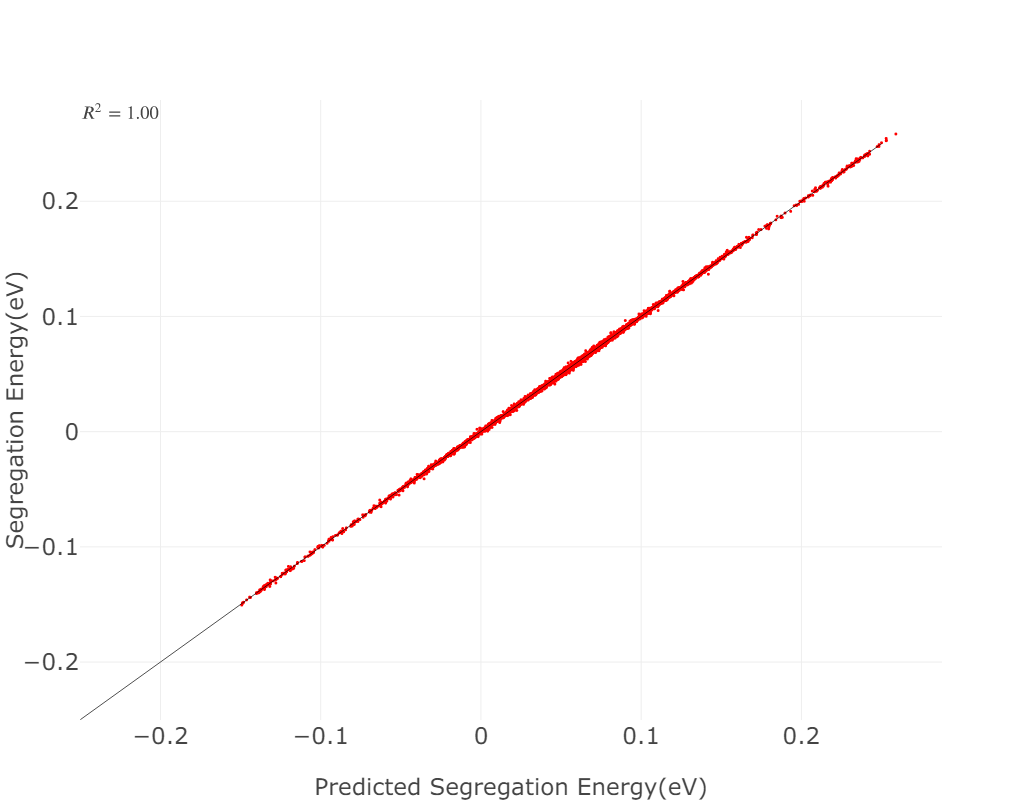

In [16]:
#draw correlation training set
main = go.Scatter(x = model.predict(dtrain), 
          y = dtrain.get_label(), 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 23)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':0.25,
                            'y0':-0.25,
                            'y1':0.25,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

In [18]:
Y_mean = np.mean(Y_cos)
SS_tot = np.sum(np.power(Y_cos - Y_mean, 2))
SS_res = np.power(np.linalg.norm(model.predict(dcos) - dcos.get_label()), 2)
R_squared = 1-SS_res/SS_tot
R_squared = 1-(1-R_squared)*(X_train.shape[0]-1)/(X_train.shape[0]-1-X_train.shape[1])

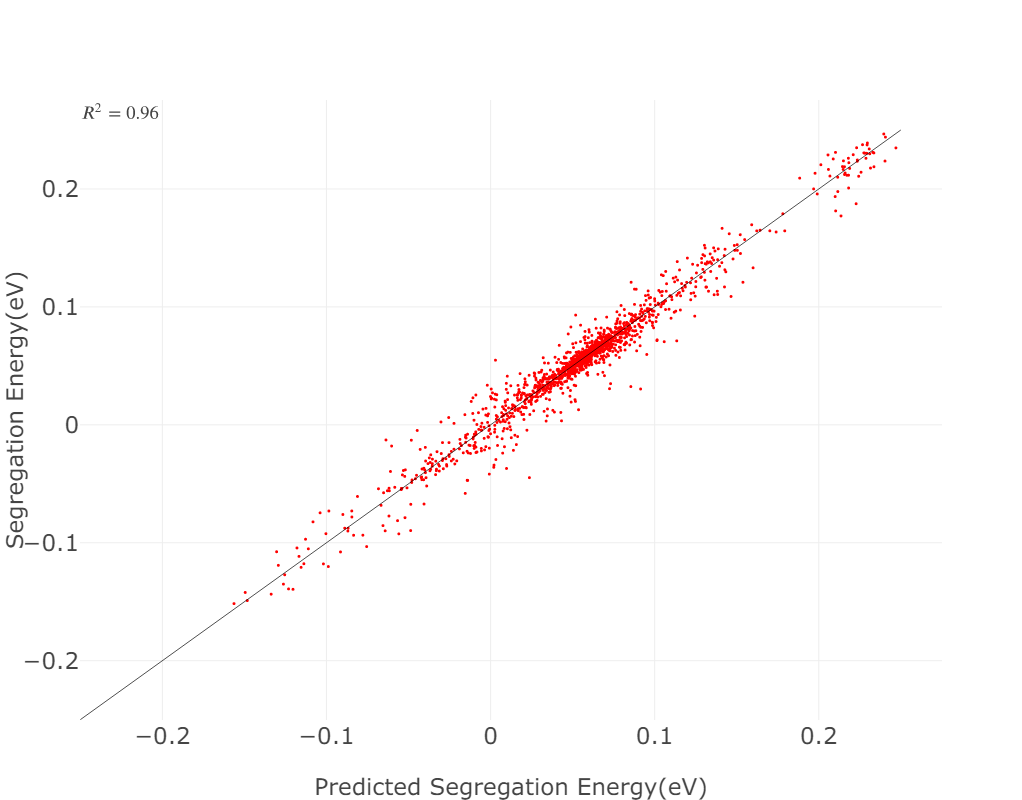

In [19]:
#draw correlation cross validation set
main = go.Scatter(x = model.predict(dcos), 
          y = dcos.get_label(), 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 23)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':0.25,
                            'y0':-0.25,
                            'y1':0.25,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

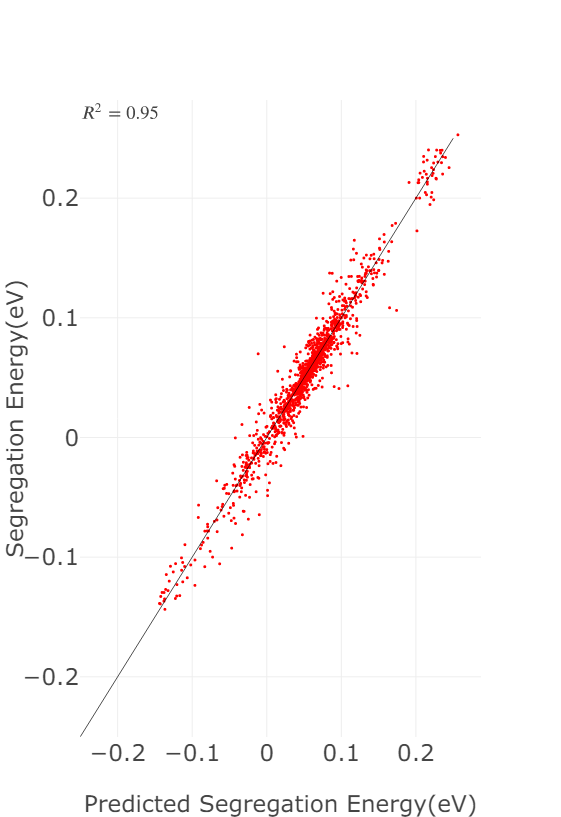

In [64]:
#draw correlation
main = go.Scatter(x = model.predict(dtest), 
          y = dtest.get_label(), 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 23)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':0.25,
                            'y0':-0.25,
                            'y1':0.25,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))